In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot
import numpy as np
import os
import PIL
import cv2
import pathlib
import glob
import shutil
import os
import random


**IMPORTING THE DATA**

In [ ]:
######################################### caution : terminal commands #######################################################

#-------------------------------------empty the datasets forlder before downloading the dataset -------------------------------------

%cd
%cd .keras/datasets/
!rm -r *

/root
/root/.keras/datasets


In [ ]:
########################################### download data from given url ###############################################3

dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
data_dir = tf.keras.utils.get_file('nature_12K', origin=dataset_url, extract=True)


3816693760/3816687935 [==============================] - 65s 0us/step


**SPLITTING THE DATA**

In [ ]:
#---------------------------------------------caution : terminal commands ----------------------------------------------

%cd
%cd .keras/datasets/inaturalist_12K
%mv val test
!mkdir valid

/root
/root/.keras/datasets/inaturalist_12K


In [ ]:
#################################### split train data into validation set and training set ###################################

data_folder = '/root/.keras/datasets/inaturalist_12K'
os.chdir(data_folder)

folder_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia' ]
for i in range(0,10):
  source = data_folder + "/train/" +folder_names[i]  
  orig_files = os.listdir(source)
  chosen_indexes = random.sample(range(0, len(orig_files)-1), 100)

  destination = data_folder + "/valid/"
  os.chdir(destination)
  os.system('mkdir'+' '+str(folder_names[i]))
  destination = destination + folder_names[i]
  for j in range(0,100):
    shutil.move(   source +"/" + str(   orig_files[   chosen_indexes[j]  ]   )  , destination)


In [ ]:
####################################### Correcting the directory location ####################################################

#data_dir = '/root/.keras/datasets/nature_12K'

data_dir = data_dir.split('/')
data_dir.remove('nature_12K')
data_dir.append('inaturalist_12K')
data_dir = '/'.join(data_dir)


In [ ]:
#-------------------------------------Taking the train data--------------------------------------------------------
train_data_dir_path = data_dir + '/train'
train_data_dir = pathlib.Path(train_data_dir_path)

#--------------------------------------Taking the validation data-----------------------------------------------
valid_data_dir_path = data_dir + '/valid'
valid_data_dir = pathlib.Path(valid_data_dir_path)

#----------------------------------------Taking the test data-----------------------------------------------
test_data_dir_path = data_dir + '/test'
test_data_dir = pathlib.Path(test_data_dir_path)

In [ ]:
#------------------------------------------Parameters for the images-------------------------------------------------
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
####################################### converting the image data into dataset ############################################

#-------------------------------------training dataset -----------------------------------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

#----------------------------------------------validation dataset -----------------------------------------------
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

#----------------------------------------------test dataset -----------------------------------------------
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 8999 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
class CNN():

############################################# constructor for class CNN ##########################################
  def __init__(self, filter_count, filter_size, active_func, dense_neurons_count, maxpool_size, output_neurons_count, data_augmentation, drop_out, batch_normalisation, optimizer='adam'):
    self.filter_count = filter_count
    self.filter_size = filter_size
    self.active_func = active_func
    self.dense_neurons_count = dense_neurons_count
    self.maxpool_size = maxpool_size
    self.num_classes = output_neurons_count
    self.optimizer = optimizer
    self.data_augmentation = data_augmentation
    self.drop_out = drop_out
    self.batch_normalisation = batch_normalisation

    #harcoded values
    self.img_height = 180
    self.img_width = 180

    #creating the CNN model
    self.model = self.create_model(5)


############################################### function to create model ####################################################
  def create_model(self, num_layers):    
    
    # #-------------------------------------------creating the CNN model -----------------------------------------------------

    augmentations = [     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                          layers.experimental.preprocessing.RandomRotation(0.1),
                          layers.experimental.preprocessing.RandomZoom(0.1)
                    ]

    data_augment = keras.Sequential(augmentations)

    layerslist = []

    #------------------Data Augmentation---------------------------------------
    if self.data_augmentation == "Yes":
      layerslist.append(data_augment)

    #------------------Including a normalisation layer in the model---------------------------------------
    layerslist.append(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.img_height, self.img_width, 3)))

    #------------------Creating (convolution,activation,maxpool) layers in the model---------------------------------------
    for i in range(0,num_layers):
      layerslist.append(layers.Conv2D(self.filter_count[i], self.filter_size[i], padding='same', activation = self.active_func[i]))
      if self.batch_normalisation[i] == 'Yes':
        layerslist.append(layers.BatchNormalization( axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
                                                     beta_initializer='zeros', gamma_initializer='ones',
                                                     moving_mean_initializer='zeros', moving_variance_initializer='ones'))
      layerslist.append(layers.MaxPooling2D(pool_size = self.maxpool_size[i]))

    layerslist.append(layers.Dropout(self.drop_out))
    layerslist.append(layers.Flatten())
    layerslist.append(layers.Dense(self.dense_neurons_count,  activation = self.active_func[num_layers]))
    # layerslist.append(layers.Dense(self.num_classes))
    layerslist.append(layers.Dense(self.num_classes, activation = "softmax"))

    model = Sequential(layerslist)

    # ---------------------------------------compiling the CNN model ----------------------------------------------------------
    model.compile(
    optimizer = self.optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] )


  #--------------------------------------------- return final model --------------------------------------------------------
    return model 


  
############################################## function for training the model ##################################################3
  def train(self, train_ds, val_ds, epochs = 10):

    #------------------------------------caching the datasets -----------------------------------------------
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #------------------------------------ training the model -----------------------------------------------
    # history = self.model.fit( train_ds, validation_data=val_ds, epochs=epochs, callbacks=[WandbCallback()] )
    history = self.model.fit( train_ds, validation_data=val_ds, epochs=epochs)

    return history
############################################ saving the model ###########################################
  def get_model(self):
    return self.model

############################################ saving the model ###########################################
  # def model_save(self, file_name):
  #   return self.model.save(file_name)

############################################ function for summary of model ###########################################
  def model_summary(self):
    return self.model.summary()

############################################ function for testing the model ###########################################
  def test(self, test_ds):  
      predictions = self.model.predict(test_ds)
      return predictions

#=============================================== end of class CNN ======================================================
    

In [ ]:
# sweep parameters
filter_count = [16,32,64,128,256]
filter_size = [3,3,3,3,3]
data_augmentation = "No"
drop_out = 0.2
batch_normalisation = ["Yes","Yes","Yes","Yes","Yes"]
epochs = 10

#fixed parameters
maxpool_size = [2,2,2,2,2]
active_func = ['relu']*6
dense_neurons_count = 120
output_neurons_count = 10


cnn = CNN(filter_count, filter_size, active_func, dense_neurons_count, maxpool_size, output_neurons_count, data_augmentation, drop_out, batch_normalisation)


In [ ]:
#training the model
history = cnn.train(train_ds, val_ds, epochs)

Epoch 1/10
282/282 [==============================] - 102s 61ms/step - loss: 2.6255 - accuracy: 0.1953 - val_loss: 2.3572 - val_accuracy: 0.1100
Epoch 2/10
282/282 [==============================] - 8s 27ms/step - loss: 2.0498 - accuracy: 0.2794 - val_loss: 2.1437 - val_accuracy: 0.2460
Epoch 3/10
282/282 [==============================] - 8s 28ms/step - loss: 1.9272 - accuracy: 0.3117 - val_loss: 2.1661 - val_accuracy: 0.2840
Epoch 4/10
282/282 [==============================] - 8s 28ms/step - loss: 1.7953 - accuracy: 0.3576 - val_loss: 1.9674 - val_accuracy: 0.3020
Epoch 5/10
282/282 [==============================] - 8s 28ms/step - loss: 1.7194 - accuracy: 0.3829 - val_loss: 2.0848 - val_accuracy: 0.2740
Epoch 6/10
282/282 [==============================] - 8s 28ms/step - loss: 1.6609 - accuracy: 0.4049 - val_loss: 1.8882 - val_accuracy: 0.3480
Epoch 7/10
282/282 [==============================] - 8s 28ms/step - loss: 1.5303 - accuracy: 0.4463 - val_loss: 1.9610 - val_accuracy: 0.33

In [ ]:
model = cnn.get_model()
model.summary()

**Q4(c) Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an 8 x 8 grid.**

**VISUALISATION OF FILTERS OF FIRST LAYER AFTER TRAINING**

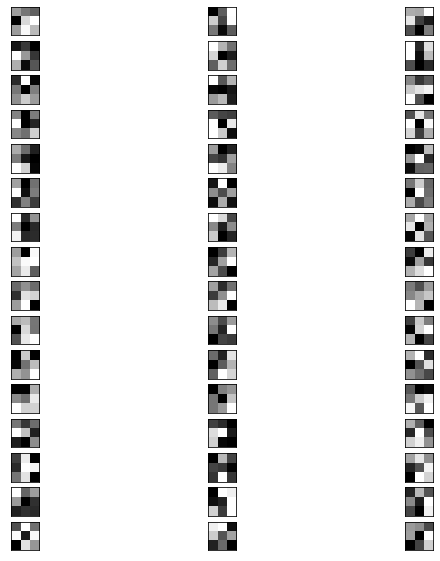

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 16, 1
pyplot.figure(figsize=(10, 10))
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
    pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

**VISUALISATION OF FEATURE MAPS OF FIRST LAYER**

In [ ]:
#Place the path of your image here
img_path = '/root/.keras/datasets/inaturalist_12K/test/Mammalia/4383ad062440dd5f673f50aa04587ee0.jpg'

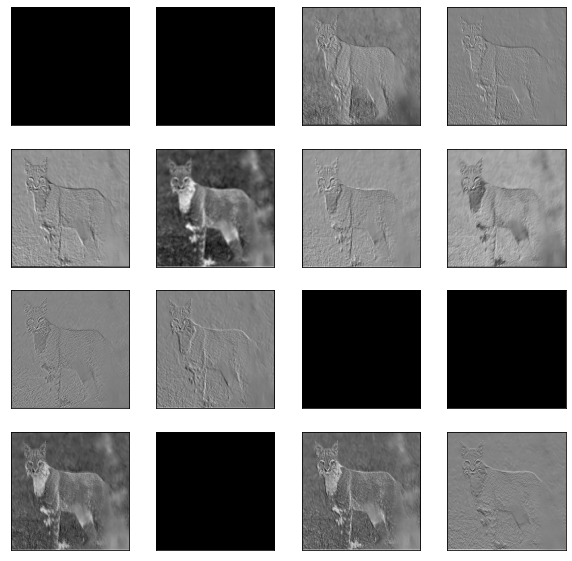

In [ ]:
model = cnn.get_model()
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

# load the image with the required shape
img = load_img(img_path, target_size=(180, 180))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = layers.experimental.preprocessing.Rescaling(1./255)(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 4
ix = 1
pyplot.figure(figsize=(10, 10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()